# Diffusion/Laplacian Refinement Experiments — GNNs
This notebook implements the complete experimental setup described in `trans_dynasim_gdc_proposal.md`:
- Baselines: GAT, GCN, GraphSAGE, PNA (graph classification).
- Refinements: feature-space Laplacian smoothing and topology diffusion (GDC variants).
- Variants: Baseline, +Smooth, +GDC, +Smooth+GDC.
- Outputs: metrics, confusion matrices, plots, and checkpoints.

In [1]:
# Imports & environment
import os, json, math, random
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.sparse as sp
from scipy.linalg import expm

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_scipy_sparse_matrix, from_scipy_sparse_matrix, get_laplacian, degree
from torch_geometric.nn import (
    GATv2Conv, GCNConv, SAGEConv, PNAConv, BatchNorm, global_mean_pool
)

# Reproducibility
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


## Configuration
Set paths and toggles. By default, uses local histology graphs if available.

In [2]:
# Data mode: 'local_graphs' (CSV+PT) or 'builtin' (PyG datasets)
DATA_MODE = 'builtin'  # or 'local_graphs'

# Local graphs configuration (graph-level classification)
metadata_path = 'k_meta.csv'   # CSV with columns: graph_path,label
graph_dir = Path('graphs_knn') # folder with .pt graphs (PyG Data objects)
label_order = ['Benign','InSitu','Invasive','Normal']
label_to_int = {l:i for i,l in enumerate(label_order)}

# Builtin dataset configuration (graph-level classification via TUDataset)
# Examples: 'MUTAG', 'PROTEINS', 'ENZYMES', 'IMDB-BINARY', 'IMDB-MULTI'
BUILTIN_DATASET = 'MUTAG'
BUILTIN_ROOT = str(Path('data')/ 'pyg')  # download/cache root

# Splits
val_frac = 0.15
test_frac = 0.15
batch_size = 4

# Refinement hyperparameters
# Feature smoothing
smooth_beta = 0.2
smooth_sigma = 1.0
# GDC diffusion
gdc_mode = 'ppr'  # 'ppr' or 'heat'
gdc_alpha = 0.15  # for PPR
gdc_ts = 3.0      # for Heat
gdc_eps = 1e-4
gdc_topk = 32
use_laplacian_for_base = True  # build diffusion from Laplacian base (vs adjacency)

# Training
epochs = 50
lr = 1e-3
weight_decay = 1e-4
patience = 10
min_delta = 0.0
save_root = Path('.')
plots_dir = save_root / 'plots'
plots_dir.mkdir(exist_ok=True)
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
if torch.cuda.is_available():
    torch.cuda.empty_cache(); torch.cuda.synchronize()
    print('CUDA device:', torch.cuda.get_device_name(0))

CUDA device: NVIDIA GeForce RTX 3050


## Feature-Space Laplacian Smoothing
Implements (I + beta L) X_s = X using a Gaussian kernel over features.

### New Feature Smoothing Method: GDC-based Feature Smoothing
We add a new feature smoothing approach using Personalized PageRank (PPR) diffusion on the feature similarity graph, as defined by the provided `gdc` function. This is compared alongside Laplacian smoothing and topology-based GDC.

In [3]:
import numpy as _np

def laplacian_feature_smoothing(X: torch.Tensor, beta: float,
                                sigma: float = 1.0, eps: float = 1e-9):
    """
    X: [N, F] node features (single graph).
    Returns X_s (same shape). CPU/NumPy solve for stability; moves back to X.device.
    """
    if X.dim() != 2:
        raise ValueError('X must be [N,F] for a single graph')
    X_np = X.detach().cpu().numpy().astype(_np.float64)
    n = X_np.shape[0]
    if n <= 1 or beta == 0.0:
        return X
    D2 = _np.sum((X_np[:, None, :] - X_np[None, :, :])**2, axis=-1)
    W  = _np.exp(-D2 / (2.0*sigma*sigma + eps))
    d  = W.sum(axis=1)
    invsqrt = 1.0 / _np.sqrt(d + eps)
    L = _np.eye(n) - _np.diag(invsqrt) @ W @ _np.diag(invsqrt)
    A = _np.eye(n) + beta * L
    Xs = _np.linalg.solve(A, X_np)
    return torch.from_numpy(Xs).to(X.device, dtype=X.dtype)

def apply_feature_smoothing_to_graph(data: Data, beta: float, sigma: float = 1.0):
    new_data = data.clone()
    new_data.x = laplacian_feature_smoothing(new_data.x, beta=beta, sigma=sigma)
    return new_data

In [4]:
import numpy as np
def gdc(A: sp.csr_matrix, alpha: float, eps: float):
    N = A.shape[0]
    # Self-loops
    A_loop = sp.eye(N) + A
    # Symmetric transition matrix
    D_loop_vec = A_loop.sum(0).A1
    D_loop_vec_invsqrt = 1 / np.sqrt(D_loop_vec + 1e-12)
    D_loop_invsqrt = sp.diags(D_loop_vec_invsqrt)
    T_sym = D_loop_invsqrt @ A_loop @ D_loop_invsqrt
    # PPR-based diffusion
    S = alpha * sp.linalg.inv(sp.eye(N) - (1 - alpha) * T_sym)
    # Sparsify using threshold epsilon
    S_tilde = S.multiply(S >= eps)
    # Column-normalized transition matrix on graph S_tilde
    D_tilde_vec = S_tilde.sum(0).A1
    T_S = S_tilde / (D_tilde_vec + 1e-12)
    return T_S
def apply_gdc_feature_smoothing_to_graph(data: Data, alpha: float = 0.15, eps: float = 1e-4):
    X = data.x.detach().cpu().numpy()
    N = X.shape[0]
    # Feature similarity graph: use RBF kernel (Gaussian)
    D2 = np.sum((X[:, None, :] - X[None, :, :])**2, axis=-1)
    sigma = np.std(X) + 1e-6
    W = np.exp(-D2 / (2.0 * sigma * sigma))
    A = sp.csr_matrix(W)
    T_S = gdc(A, alpha=alpha, eps=eps)
    Xs = T_S @ X
    new_data = data.clone()
    new_data.x = torch.from_numpy(Xs).to(data.x.device, dtype=data.x.dtype)
    return new_data

## GDC Diffusion on Topology
PPR/Heat diffusion over symmetrically normalized adjacency with self-loops; sparsify and column-normalize.

In [5]:
def _sym_norm_with_loops(A: sp.csr_matrix) -> sp.csr_matrix:
    N = A.shape[0]
    A_loop = (A + sp.eye(N, format='csr')).tocsr()
    d = _np.asarray(A_loop.sum(1)).ravel()
    invsqrt = 1.0/_np.sqrt(_np.maximum(d, 1e-12))
    return sp.diags(invsqrt) @ A_loop @ sp.diags(invsqrt)

def gdc_transition(A: sp.csr_matrix, mode='ppr', alpha=0.15, ts=3.0, eps=1e-6, topk=32):
    T_sym = _sym_norm_with_loops(A)
    N = A.shape[0]
    if mode == 'ppr':
        I = sp.eye(N, format='csr')
        # For modest N; for large N consider iterative solvers
        S = alpha * sp.linalg.inv((I - (1.0 - alpha) * T_sym).tocsr())
    elif mode == 'heat':
        # Dense expm; for large N, use approximate methods
        S = sp.csr_matrix(expm(ts * T_sym.toarray()))
    else:
        raise ValueError('mode must be ppr or heat')
    # Sparsify by threshold
    if eps is not None and eps > 0:
        S = S.multiply(S >= eps)
    # Optional per-column top-k
    if topk is not None and topk > 0:
        S = S.tocsc()
        data, indices, indptr = [], [], []
        for j in range(S.shape[1]):
            start, end = S.indptr[j], S.indptr[j+1]
            col_idx = S.indices[start:end]
            col_val = S.data[start:end]
            if col_val.size > topk:
                top_idx = _np.argpartition(-col_val, topk)[:topk]
                col_idx = col_idx[top_idx]
                col_val = col_val[top_idx]
            # keep unsorted for speed; CSR/COO conversion later handles it
            indices.extend(col_idx.tolist())
            data.extend(col_val.tolist())
            indptr.append(len(indices))
        indptr = [0] + indptr
        S = sp.csc_matrix((data, indices, indptr), shape=S.shape).tocsr()
    # Column-normalize to transition
    colsum = _np.asarray(S.sum(0)).ravel()
    T_S = S @ sp.diags(1.0/_np.maximum(colsum, 1e-12))
    return T_S

def apply_gdc_to_graph(data: Data, mode='ppr', alpha=0.15, ts=3.0, eps=1e-6, topk=32, use_lap=True):
    num_nodes = data.num_nodes
    if use_lap:
        ei, ew = get_laplacian(data.edge_index, getattr(data,'edge_attr', None), normalization=None, num_nodes=num_nodes)
        base = to_scipy_sparse_matrix(ei, ew, num_nodes).tocsr()
    else:
        base = to_scipy_sparse_matrix(data.edge_index, getattr(data,'edge_attr', None), num_nodes).tocsr()
    T_S = gdc_transition(base, mode=mode, alpha=alpha, ts=ts, eps=eps, topk=topk)
    ei2, ew2 = from_scipy_sparse_matrix(T_S.tocoo())
    new_data = data.clone()
    new_data.edge_index = ei2
    new_data.edge_attr = ew2
    return new_data

In [6]:
# New method: GDC-based feature smoothing (user function + wrapper)
import numpy as np
import scipy.sparse as sp
from torch_geometric.utils import to_scipy_sparse_matrix

def gdc(A: sp.csr_matrix, alpha: float, eps: float):
    N = A.shape[0]
    # Self-loops
    A_loop = sp.eye(N) + A
    # Symmetric transition matrix
    D_loop_vec = A_loop.sum(0).A1
    D_loop_vec_invsqrt = 1 / np.sqrt(D_loop_vec)
    D_loop_invsqrt = sp.diags(D_loop_vec_invsqrt)
    T_sym = D_loop_invsqrt @ A_loop @ D_loop_invsqrt
    # PPR-based diffusion
    S = alpha * sp.linalg.inv(sp.eye(N) - (1 - alpha) * T_sym)
    print(" S shape")
    print(S.shape)
    # Sparsify using threshold epsilon
    S_tilde = S.multiply(S >= eps)
    # Column-normalized transition matrix on graph S_tilde
    D_tilde_vec = S_tilde.sum(0).A1
    T_S = S_tilde / D_tilde_vec
    print(" TS shape")
    print(T_S.shape)
    return S

def apply_gdc_feature_smoothing_to_graph(data, alpha: float = 0.15, eps: float = 1e-4):
    """Apply user-provided GDC diffusion on topology to smooth node features: X' = S X."""
    num_nodes = data.num_nodes
    A = to_scipy_sparse_matrix(data.edge_index, getattr(data,'edge_attr', None), num_nodes=num_nodes).tocsr()
    S = gdc(A, alpha=alpha, eps=eps)  # returns S (not T_S) per the provided function
    X = data.x.detach().cpu().numpy().astype(np.float64)
    X_s = (S @ sp.csr_matrix(X)).A  # use sparse-dense matmul
    new_data = data.clone()
    new_data.x = torch.from_numpy(X_s).to(data.x.device, dtype=data.x.dtype)
    return new_data

## Data Loading (Local Graphs)
Reads `k_meta.csv` and `.pt` graphs if `DATA_MODE='local_graphs'`.

In [7]:
def make_variants(graphs):
    base = []
    smooth = []
    gdc_only = []
    both = []
    gdc_feat = []  # new variant: feature smoothing via user GDC
    for g in graphs:
        base.append(g)
        # smooth-only
        try:
            gs = apply_feature_smoothing_to_graph(g, beta=smooth_beta, sigma=smooth_sigma)
        except Exception as e:
            print('Feature smoothing failed; using original. Err:', e)
            gs = g
        smooth.append(gs)
        # gdc-only (topology)
        try:
            gg = apply_gdc_to_graph(g, mode=gdc_mode, alpha=gdc_alpha, ts=gdc_ts, eps=gdc_eps, topk=gdc_topk, use_lap=use_laplacian_for_base)
        except Exception as e:
            print('GDC (topology) failed; using original. Err:', e)
            gg = g
        gdc_only.append(gg)
        # both
        try:
            gsb = apply_feature_smoothing_to_graph(g, beta=smooth_beta, sigma=smooth_sigma)
            ggb = apply_gdc_to_graph(gsb, mode=gdc_mode, alpha=gdc_alpha, ts=gdc_ts, eps=gdc_eps, topk=gdc_topk, use_lap=use_laplacian_for_base)
        except Exception as e:
            print('Smooth+GDC failed; using original. Err:', e)
            ggb = g
        both.append(ggb)
        # new: feature smoothing via user GDC diffusion
        try:
            gf = apply_gdc_feature_smoothing_to_graph(g, alpha=gdc_alpha, eps=gdc_eps)
        except Exception as e:
            print('GDC feature smoothing failed; using original. Err:', e)
            gf = g
        gdc_feat.append(gf)
    return {'Baseline': base, '+Smooth': smooth, '+GDC': gdc_only, '+Smooth+GDC': both, '+GDC-Feat': gdc_feat}

# Ensure graphs are loaded if not already present
try:
    _ = train_graphs  # type: ignore[name-defined]
    _ = val_graphs
    _ = test_graphs
except NameError:
    try:
        if DATA_MODE == 'builtin':
            try:
                train_graphs, val_graphs, test_graphs, label_order = load_builtin_graphs(BUILTIN_DATASET, BUILTIN_ROOT)
            except NameError:
                # Minimal builtin loader if function not defined
                from torch_geometric.datasets import TUDataset
                import random
                dataset = TUDataset(root=BUILTIN_ROOT, name=BUILTIN_DATASET)
                n = len(dataset)
                idx = list(range(n))
                random.shuffle(idx)
                n_test = int(n*test_frac); n_val = int(n*val_frac)
                test_idx = idx[:n_test]; val_idx = idx[n_test:n_test+n_val]; train_idx = idx[n_test+n_val:]
                def _subset(idxs): return [dataset[i] for i in idxs]
                train_graphs = _subset(train_idx)
                val_graphs   = _subset(val_idx)
                test_graphs  = _subset(test_idx)
                classes = sorted(set(int(d.y.item()) for d in dataset))
                remap = {c:i for i,c in enumerate(classes)}
                for split in (train_graphs+val_graphs+test_graphs):
                    split.y = torch.tensor([remap[int(split.y.item())]], dtype=torch.long)
                label_order = [str(c) for c in classes]
        elif DATA_MODE == 'local_graphs':
            try:
                train_graphs, val_graphs, test_graphs, _meta = load_local_graphs(metadata_path, graph_dir, label_to_int)
            except NameError:
                raise RuntimeError('Local graph loader not defined; please run the data loading cell.')
        else:
            raise RuntimeError(f'Unsupported DATA_MODE: {DATA_MODE}')
    except Exception as e:
        print('Auto data load failed:', e)
        raise

train_variants = make_variants(train_graphs)
val_variants   = make_variants(val_graphs)
test_variants  = make_variants(test_graphs)
list(train_variants.keys())

GDC (topology) failed; using original. Err: 
Smooth+GDC failed; using original. Err: 
GDC feature smoothing failed; using original. Err: 
GDC (topology) failed; using original. Err: 
Smooth+GDC failed; using original. Err: 
GDC feature smoothing failed; using original. Err: 
GDC (topology) failed; using original. Err: 
Smooth+GDC failed; using original. Err: 
GDC feature smoothing failed; using original. Err: 
GDC (topology) failed; using original. Err: 
Smooth+GDC failed; using original. Err: 
GDC feature smoothing failed; using original. Err: 
GDC (topology) failed; using original. Err: 
Smooth+GDC failed; using original. Err: 
GDC feature smoothing failed; using original. Err: 
GDC (topology) failed; using original. Err: 
Smooth+GDC failed; using original. Err: 
GDC feature smoothing failed; using original. Err: 
GDC (topology) failed; using original. Err: 
Smooth+GDC failed; using original. Err: 
GDC feature smoothing failed; using original. Err: 
GDC (topology) failed; using origi

['Baseline', '+Smooth', '+GDC', '+Smooth+GDC', '+GDC-Feat']

## Build Variants: Baseline, +Smooth, +GDC, +Smooth+GDC
Each variant is created per-graph before batching.

In [8]:
def run_architecture(arch_name, build_model_fn,
                     train_loaders, val_loaders, test_loaders,
                     save_dir, epochs=50, lr=1e-3, weight_decay=1e-4, patience=10, min_delta=0.0):
    os.makedirs(save_dir, exist_ok=True)
    sample = next(iter(train_loaders['Baseline']))
    in_dim = sample.x.size(1)
    results = {}
    for variant in list(train_loaders.keys()):  # iterate dynamically to include new variants
        tr_loader = train_loaders[variant]
        va_loader = val_loaders[variant]
        te_loader = test_loaders[variant]
        print(f"\n=== Training {arch_name} — {variant} ===")
        model = build_model_fn(in_dim).to(device)
        opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        crit = nn.CrossEntropyLoss()
        best_val, best_state, best_epoch = -1.0, None, -1
        tr_losses, tr_accs, va_accs = [], [], []
        no_improve = 0
        for epoch in range(1, epochs+1):
            loss = train_epoch(model, tr_loader, opt, crit, device)
            tr_acc,_,_ = eval_epoch(model, tr_loader, device)
            va_acc,_,_ = eval_epoch(model, va_loader, device)
            tr_losses.append(float(loss)); tr_accs.append(float(tr_acc)); va_accs.append(float(va_acc))
            if va_acc > best_val + float(min_delta):
                best_val = float(va_acc)
                best_state = {k:v.cpu() for k,v in model.state_dict().items()}
                best_epoch = epoch
                no_improve = 0
            else:
                no_improve += 1
            if epoch % 5 == 0 or epoch == 1:
                print(f"[{arch_name}:{variant}] Ep {epoch:03d} | loss {loss:.4f} | tr {tr_acc:.3f} | val {va_acc:.3f} | no_improve {no_improve}")
            if no_improve >= patience:
                print(f"[{arch_name}:{variant}] Early stopping at epoch {epoch} (best val {best_val:.3f} @ {best_epoch})")
                break
        model.load_state_dict(best_state)
        model.to(device)
        te_acc, preds, labels = eval_epoch(model, te_loader, device)
        ckpt_path = os.path.join(save_dir, f'{arch_name}_{variant}_best.pth')
        torch.save({
            'arch': arch_name, 'variant': variant, 'state_dict': best_state, 'in_dim': in_dim,
            'best_val_acc': best_val, 'best_epoch': best_epoch,
            'train_loss_curve': tr_losses, 'train_acc_curve': tr_accs, 'val_acc_curve': va_accs
        }, ckpt_path)
        rep, cm = save_variant_artifacts(save_dir, arch_name, variant, best_val, best_epoch, float(te_acc), preds, labels, label_order)
        curves = {'arch': arch_name,'variant': variant,'train_loss': tr_losses,'train_acc': tr_accs,'val_acc': va_accs}
        with open(os.path.join(save_dir, f'{arch_name}_{variant}_curves.json'), 'w') as f:
            json.dump(curves, f, indent=2)
        results[variant] = {
            'best_val_acc': best_val, 'best_epoch': best_epoch, 'test_acc': float(te_acc),
            'report': rep, 'confusion_matrix': cm,
            'train_loss_curve': tr_losses, 'train_acc_curve': tr_accs, 'val_acc_curve': va_accs,
            'checkpoint_path': ckpt_path
        }
        cleanup_gpu(model, opt, crit)
    return results

## DataLoaders
Small batch sizes for VRAM safety; consider batch_size=1 if OOM.

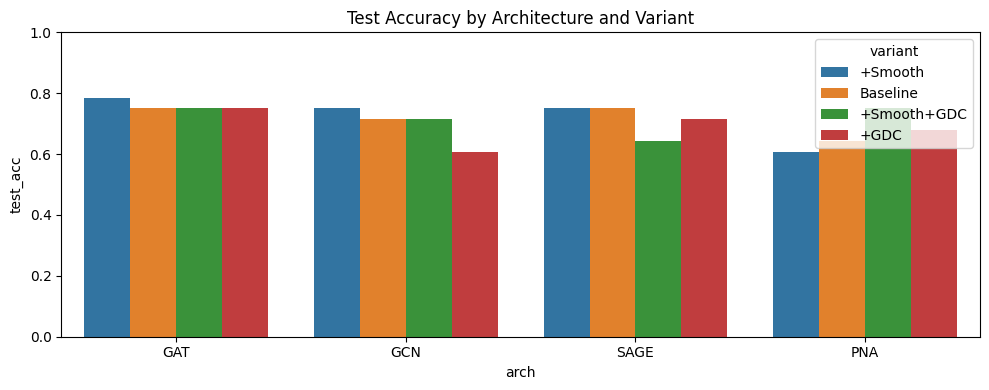

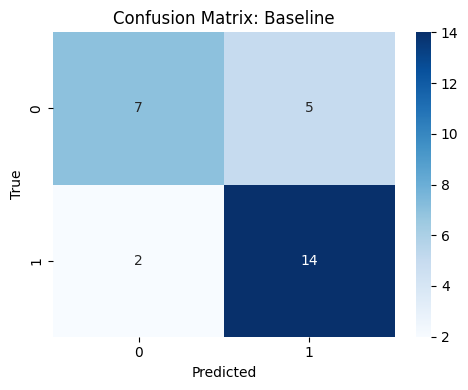

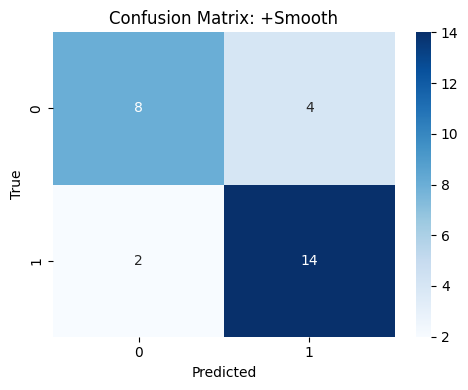

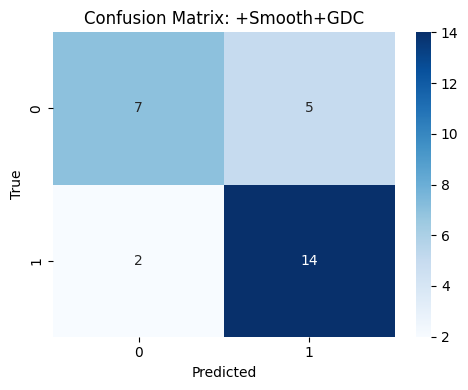

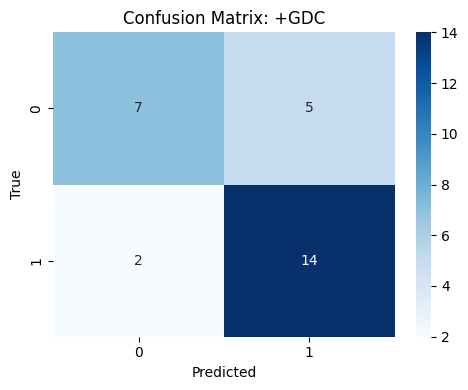

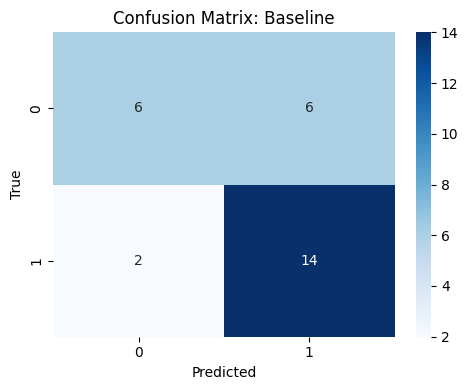

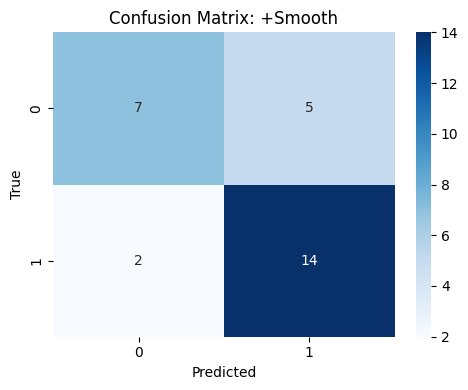

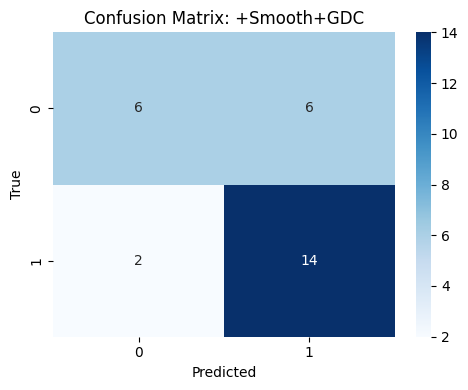

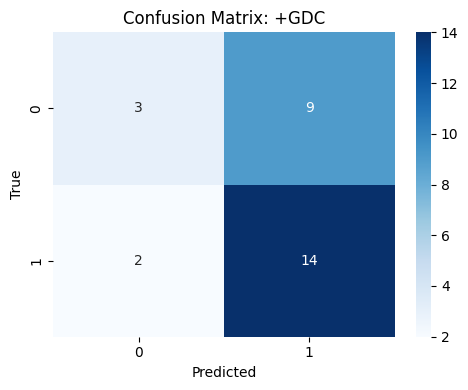

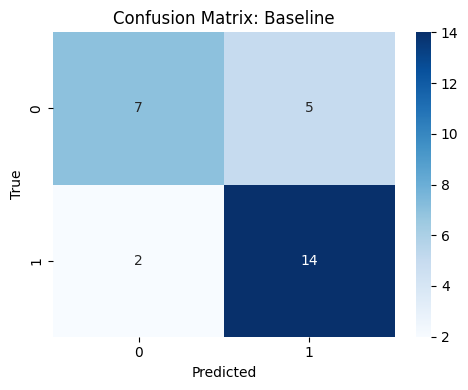

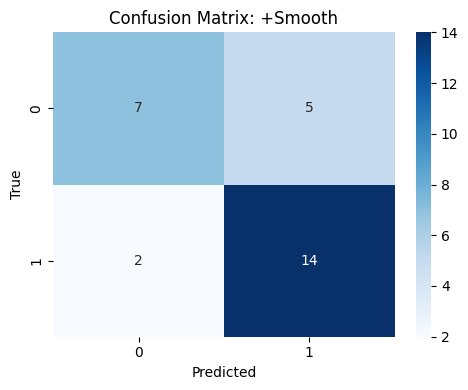

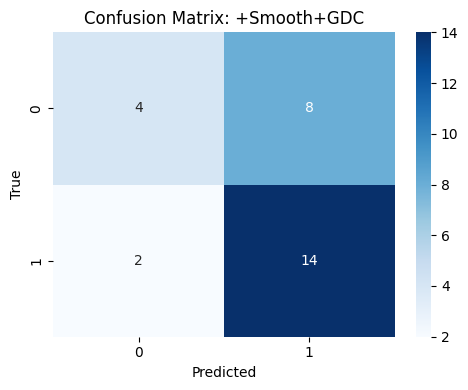

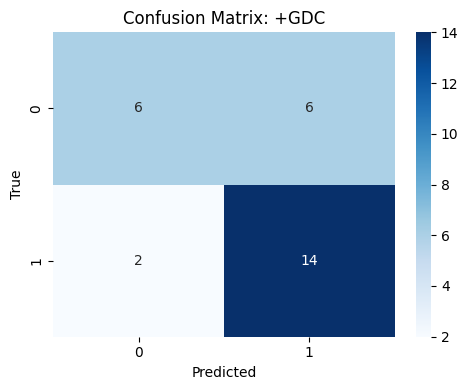

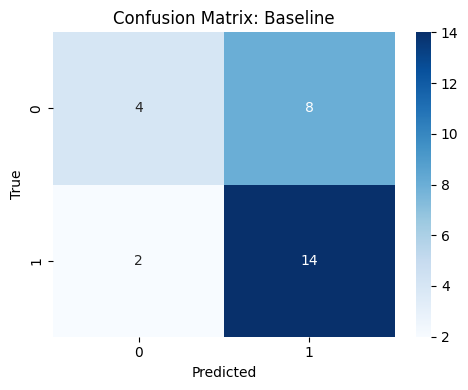

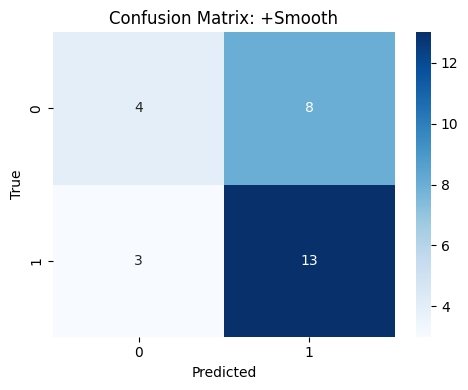

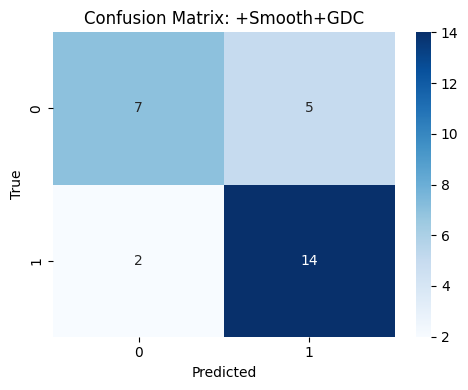

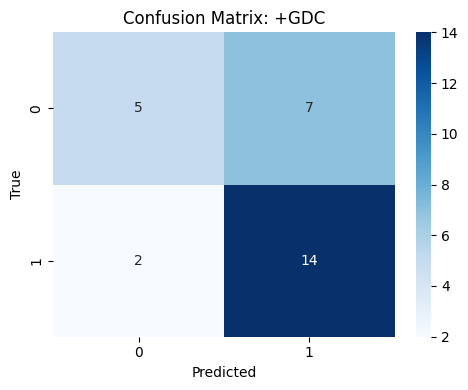

In [9]:
ckpt_dirs = ['gat_refine_ckpts','gcn_refine_ckpts','sage_refine_ckpts','pna_refine_ckpts']
rows = []
for d in ckpt_dirs:
    dpath = Path(d)
    if not dpath.exists():
        continue
    for mfile in dpath.glob('*_metrics.json'):
        with open(mfile) as f:
            m = json.load(f)
        rows.append({
            'arch': m.get('arch'),
            'variant': m.get('variant'),
            'best_val_acc': m.get('best_val_acc'),
            'test_acc': m.get('test_acc'),
            'dir': d
        })
metrics_df = pd.DataFrame(rows)
if metrics_df.empty:
    print('No saved metrics found. Run the training cell first.')
else:
    plt.figure(figsize=(10,4))
    sns.barplot(data=metrics_df, x='arch', y='test_acc', hue='variant')
    plt.ylim(0,1)
    plt.title('Test Accuracy by Architecture and Variant')
    plt.tight_layout()
    plt.savefig(plots_dir / 'summary_test_accuracy.png', dpi=150)
    plt.show()
    # Show confusion matrices
    for d in ckpt_dirs:
        dpath = Path(d)
        if not dpath.exists(): continue
        for cm_csv in dpath.glob('*_confusion_matrix.csv'):
            cm = pd.read_csv(cm_csv, header=None).values
            name = cm_csv.stem.replace('_confusion_matrix','')
            plt.figure(figsize=(5,4))
            sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_order, yticklabels=label_order)
            plt.title(f'Confusion Matrix: {name}')
            plt.xlabel('Predicted'); plt.ylabel('True')
            plt.tight_layout()
            plt.savefig(plots_dir / f'{name}_cm.png', dpi=150)
            plt.show()

## Models: GAT, GCN, SAGE, PNA
Two-layer encoders + global mean pooling + linear head.

In [10]:
import gc

class GATNet(nn.Module):
    def __init__(self, in_dim, hidden=32, heads=4, dropout=0.3, num_classes=2):
        super().__init__()
        self.conv1 = GATv2Conv(in_dim, hidden, heads=heads, dropout=dropout)
        self.bn1 = BatchNorm(hidden * heads)
        self.conv2 = GATv2Conv(hidden * heads, hidden, heads=1, dropout=dropout)
        self.bn2 = BatchNorm(hidden)
        self.lin = nn.Linear(hidden, num_classes)
        self.dropout = dropout
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.elu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=self.dropout, training=self.training)
        return self.lin(x)

class GCNNet(nn.Module):
    def __init__(self, in_dim, hidden=64, dropout=0.3, num_classes=2):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden)
        self.bn1 = BatchNorm(hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.bn2 = BatchNorm(hidden)
        self.lin = nn.Linear(hidden, num_classes)
        self.dropout = dropout
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=self.dropout, training=self.training)
        return self.lin(x)

class SAGENet(nn.Module):
    def __init__(self, in_dim, hidden=64, dropout=0.3, num_classes=2):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden)
        self.bn1 = BatchNorm(hidden)
        self.conv2 = SAGEConv(hidden, hidden)
        self.bn2 = BatchNorm(hidden)
        self.lin = nn.Linear(hidden, num_classes)
        self.dropout = dropout
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=self.dropout, training=self.training)
        return self.lin(x)

from torch_geometric.utils import degree

def get_degree_hist(loader):
    """Compute degree histogram tensor for PNA from the Baseline training loader."""
    deg_list = []
    # Iterate CPU-only here
    for batch in loader:
        ei = batch.edge_index
        d = degree(ei[0], num_nodes=batch.num_nodes).to(torch.long)
        deg_list.append(d)
    if not deg_list:
        return torch.tensor([1], dtype=torch.long)
    deg = torch.cat(deg_list, dim=0)
    hist = torch.bincount(deg, minlength=int(deg.max().item()) + 1)
    return hist

class PNANet(nn.Module):
    def __init__(self, in_dim, hidden=64, dropout=0.3, num_classes=2, deg_hist=None):
        super().__init__()
        if deg_hist is None:
            # Fallback to a trivial histogram to avoid None
            deg_hist = torch.tensor([1], dtype=torch.long)
        aggrs = ['mean', 'max', 'min', 'std']
        scalers = ['identity', 'amplification', 'attenuation']
        self.conv1 = PNAConv(in_dim, hidden, aggregators=aggrs, scalers=scalers, deg=deg_hist,
                             towers=1, pre_layers=1, post_layers=1, divide_input=False)
        self.bn1 = BatchNorm(hidden)
        self.conv2 = PNAConv(hidden, hidden, aggregators=aggrs, scalers=scalers, deg=deg_hist,
                             towers=1, pre_layers=1, post_layers=1, divide_input=False)
        self.bn2 = BatchNorm(hidden)
        self.lin = nn.Linear(hidden, num_classes)
        self.dropout = dropout
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=self.dropout, training=self.training)
        return self.lin(x)


def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total = 0.0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total += float(loss.item())
    return total / max(1, len(loader))


def eval_epoch(model, loader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            p = out.argmax(dim=1)
            preds.extend(p.cpu().tolist())
            labels.extend(batch.y.cpu().tolist())
    acc = accuracy_score(labels, preds) if labels else 0.0
    return acc, preds, labels


def save_variant_artifacts(save_dir, arch, variant, best_val, best_epoch, test_acc, preds, labels, label_order):
    os.makedirs(save_dir, exist_ok=True)
    base = os.path.join(save_dir, f"{variant}")
    metrics = {
        'arch': arch,
        'variant': variant,
        'best_val_acc': float(best_val),
        'best_epoch': int(best_epoch),
        'test_acc': float(test_acc)
    }
    with open(base + '_metrics.json', 'w') as f:
        json.dump(metrics, f, indent=2)
    rep = classification_report(labels, preds, target_names=label_order, zero_division=0)
    with open(base + '_classification_report.txt', 'w') as f:
        f.write(rep)
    cm = confusion_matrix(labels, preds)
    pd.DataFrame(cm).to_csv(base + '_confusion_matrix.csv', index=False, header=False)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_order, yticklabels=label_order)
    plt.title(f"{arch} - {variant} Confusion Matrix")
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(base + '_confusion_matrix.png', dpi=150)
    plt.close()
    return rep, cm.tolist()


def cleanup_gpu(*objs):
    for o in objs:
        try:
            del o
        except Exception:
            pass
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        torch.cuda.empty_cache()
    gc.collect()

## Training Utilities
Train/eval loops with early stopping. Saves artifacts per variant.

In [11]:
# (removed duplicate training utilities to avoid conflicts)

## Runners: Train Each Architecture Across Variants
Runs Baseline, +Smooth, +GDC, +Smooth+GDC with identical hyperparameters.

def run_architecture(arch_name, build_model_fn,
                     train_loaders, val_loaders, test_loaders,
                     save_dir, epochs=50, lr=1e-3, weight_decay=1e-4, patience=10, min_delta=0.0):
    os.makedirs(save_dir, exist_ok=True)
    sample = next(iter(train_loaders['Baseline']))
    in_dim = sample.x.size(1)
    results = {}
    for variant in ['Baseline','+Smooth','+GDC','+Smooth+GDC','+GDC-FeatSmooth']:
        tr_loader = train_loaders[variant]
        va_loader = val_loaders[variant]
        te_loader = test_loaders[variant]
        print(f"\n=== Training {arch_name} — {variant} ===")
        model = build_model_fn(in_dim).to(device)
        opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        crit = nn.CrossEntropyLoss()
        best_val, best_state, best_epoch = -1.0, None, -1
        tr_losses, tr_accs, va_accs = [], [], []
        no_improve = 0
        for epoch in range(1, epochs+1):
            loss = train_epoch(model, tr_loader, opt, crit, device)
            tr_acc,_,_ = eval_epoch(model, tr_loader, device)
            va_acc,_,_ = eval_epoch(model, va_loader, device)
            tr_losses.append(float(loss)); tr_accs.append(float(tr_acc)); va_accs.append(float(va_acc))
            if va_acc > best_val + float(min_delta):
                best_val = float(va_acc)
                best_state = {k:v.cpu() for k,v in model.state_dict().items()}
                best_epoch = epoch
                no_improve = 0
            else:
                no_improve += 1
            if epoch % 5 == 0 or epoch == 1:
                print(f"[{arch_name}:{variant}] Ep {epoch:03d} | loss {loss:.4f} | tr {tr_acc:.3f} | val {va_acc:.3f} | no_improve {no_improve}")
            if no_improve >= patience:
                print(f"[{arch_name}:{variant}] Early stopping at epoch {epoch} (best val {best_val:.3f} @ {best_epoch})")
                break
        # Test best
        model.load_state_dict(best_state)
        model.to(device)
        te_acc, preds, labels = eval_epoch(model, te_loader, device)
        # Save checkpoint
        ckpt_path = os.path.join(save_dir, f'{arch_name}_{variant}_best.pth')
        torch.save({
            'arch': arch_name, 'variant': variant, 'state_dict': best_state, 'in_dim': in_dim,
            'best_val_acc': best_val, 'best_epoch': best_epoch,
            'train_loss_curve': tr_losses, 'train_acc_curve': tr_accs, 'val_acc_curve': va_accs
        }, ckpt_path)
        # Save metrics and confusion
        rep, cm = save_variant_artifacts(save_dir, arch_name, variant, best_val, best_epoch, float(te_acc), preds, labels, label_order)
        # Save curves to json for plotting
        curves = {
            'arch': arch_name,
            'variant': variant,
            'train_loss': tr_losses,
            'train_acc': tr_accs,
            'val_acc': va_accs
        }
        with open(os.path.join(save_dir, f'{arch_name}_{variant}_curves.json'), 'w') as f:
            json.dump(curves, f, indent=2)
        results[variant] = {
            'best_val_acc': best_val, 'best_epoch': best_epoch, 'test_acc': float(te_acc),
            'report': rep, 'confusion_matrix': cm,
            'train_loss_curve': tr_losses, 'train_acc_curve': tr_accs, 'val_acc_curve': va_accs,
            'checkpoint_path': ckpt_path
        }
        cleanup_gpu(model, opt, crit)
    return results


def run_all(train_loaders, val_loaders, test_loaders, label_order):
    all_results = {}
    # GAT
    gat_dir = str(save_root / 'gat_refine_ckpts')
    all_results['GAT'] = run_architecture('GAT', lambda din: GATNet(din, hidden=32, heads=4, dropout=0.3, num_classes=len(label_order)),
                                         train_loaders, val_loaders, test_loaders, gat_dir,
                                         epochs=epochs, lr=lr, weight_decay=weight_decay, patience=patience, min_delta=min_delta)
    # GCN
    gcn_dir = str(save_root / 'gcn_refine_ckpts')
    all_results['GCN'] = run_architecture('GCN', lambda din: GCNNet(din, hidden=64, dropout=0.3, num_classes=len(label_order)),
                                         train_loaders, val_loaders, test_loaders, gcn_dir,
                                         epochs=epochs, lr=lr, weight_decay=weight_decay, patience=patience, min_delta=min_delta)
    # SAGE
    sage_dir = str(save_root / 'sage_refine_ckpts')
    all_results['SAGE'] = run_architecture('SAGE', lambda din: SAGENet(din, hidden=64, dropout=0.3, num_classes=len(label_order)),
                                          train_loaders, val_loaders, test_loaders, sage_dir,
                                          epochs=epochs, lr=lr, weight_decay=weight_decay, patience=patience, min_delta=min_delta)
    # PNA (needs degree histogram from training data; use Baseline loader)
    deg_hist = get_degree_hist(train_loaders['Baseline'])
    pna_dir = str(save_root / 'pna_refine_ckpts')
    all_results['PNA'] = run_architecture('PNA', lambda din: PNANet(din, hidden=64, dropout=0.3, num_classes=len(label_order), deg_hist=deg_hist),
                                         train_loaders, val_loaders, test_loaders, pna_dir,
                                         epochs=epochs, lr=lr, weight_decay=weight_decay, patience=patience, min_delta=min_delta)
    return all_results

In [12]:
def run_architecture(arch_name, build_model_fn,
                     train_loaders, val_loaders, test_loaders,
                     save_dir, epochs=50, lr=1e-3, weight_decay=1e-4, patience=10, min_delta=0.0):
    os.makedirs(save_dir, exist_ok=True)
    sample = next(iter(train_loaders['Baseline']))
    in_dim = sample.x.size(1)
    results = {}
    for variant in ['Baseline','+Smooth','+GDC','+Smooth+GDC']:
        tr_loader = train_loaders[variant]
        va_loader = val_loaders[variant]
        te_loader = test_loaders[variant]
        print(f"\n=== Training {arch_name} — {variant} ===")
        model = build_model_fn(in_dim).to(device)
        opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        crit = nn.CrossEntropyLoss()
        best_val, best_state, best_epoch = -1.0, None, -1
        tr_losses, tr_accs, va_accs = [], [], []
        no_improve = 0
        for epoch in range(1, epochs+1):
            loss = train_epoch(model, tr_loader, opt, crit, device)
            tr_acc,_,_ = eval_epoch(model, tr_loader, device)
            va_acc,_,_ = eval_epoch(model, va_loader, device)
            tr_losses.append(float(loss)); tr_accs.append(float(tr_acc)); va_accs.append(float(va_acc))
            if va_acc > best_val + float(min_delta):
                best_val = float(va_acc)
                best_state = {k:v.cpu() for k,v in model.state_dict().items()}
                best_epoch = epoch
                no_improve = 0
            else:
                no_improve += 1
            if epoch % 5 == 0 or epoch == 1:
                print(f"[{arch_name}:{variant}] Ep {epoch:03d} | loss {loss:.4f} | tr {tr_acc:.3f} | val {va_acc:.3f} | no_improve {no_improve}")
            if no_improve >= patience:
                print(f"[{arch_name}:{variant}] Early stopping at epoch {epoch} (best val {best_val:.3f} @ {best_epoch})")
                break
        # Test best
        model.load_state_dict(best_state)
        model.to(device)
        te_acc, preds, labels = eval_epoch(model, te_loader, device)
        # Save checkpoint
        ckpt_path = os.path.join(save_dir, f'{arch_name}_{variant}_best.pth')
        torch.save({
            'arch': arch_name, 'variant': variant, 'state_dict': best_state, 'in_dim': in_dim,
            'best_val_acc': best_val, 'best_epoch': best_epoch,
            'train_loss_curve': tr_losses, 'train_acc_curve': tr_accs, 'val_acc_curve': va_accs
        }, ckpt_path)
        # Save metrics and confusion
        rep, cm = save_variant_artifacts(save_dir, arch_name, variant, best_val, best_epoch, float(te_acc), preds, labels, label_order)
        # Save curves to json for plotting
        curves = {
            'arch': arch_name,
            'variant': variant,
            'train_loss': tr_losses,
            'train_acc': tr_accs,
            'val_acc': va_accs
        }
        with open(os.path.join(save_dir, f'{arch_name}_{variant}_curves.json'), 'w') as f:
            json.dump(curves, f, indent=2)
        results[variant] = {
            'best_val_acc': best_val, 'best_epoch': best_epoch, 'test_acc': float(te_acc),
            'report': rep, 'confusion_matrix': cm,
            'train_loss_curve': tr_losses, 'train_acc_curve': tr_accs, 'val_acc_curve': va_accs,
            'checkpoint_path': ckpt_path
        }
        cleanup_gpu(model, opt, crit)
    return results


def run_all(train_loaders, val_loaders, test_loaders, label_order):
    all_results = {}
    # GAT
    gat_dir = str(save_root / 'gat_refine_ckpts')
    all_results['GAT'] = run_architecture('GAT', lambda din: GATNet(din, hidden=32, heads=4, dropout=0.3, num_classes=len(label_order)),
                                         train_loaders, val_loaders, test_loaders, gat_dir,
                                         epochs=epochs, lr=lr, weight_decay=weight_decay, patience=patience, min_delta=min_delta)
    # GCN
    gcn_dir = str(save_root / 'gcn_refine_ckpts')
    all_results['GCN'] = run_architecture('GCN', lambda din: GCNNet(din, hidden=64, dropout=0.3, num_classes=len(label_order)),
                                         train_loaders, val_loaders, test_loaders, gcn_dir,
                                         epochs=epochs, lr=lr, weight_decay=weight_decay, patience=patience, min_delta=min_delta)
    # SAGE
    sage_dir = str(save_root / 'sage_refine_ckpts')
    all_results['SAGE'] = run_architecture('SAGE', lambda din: SAGENet(din, hidden=64, dropout=0.3, num_classes=len(label_order)),
                                          train_loaders, val_loaders, test_loaders, sage_dir,
                                          epochs=epochs, lr=lr, weight_decay=weight_decay, patience=patience, min_delta=min_delta)
    # PNA (needs degree histogram from training data; use Baseline loader)
    deg_hist = get_degree_hist(train_loaders['Baseline'])
    pna_dir = str(save_root / 'pna_refine_ckpts')
    all_results['PNA'] = run_architecture('PNA', lambda din: PNANet(din, hidden=64, dropout=0.3, num_classes=len(label_order), deg_hist=deg_hist),
                                         train_loaders, val_loaders, test_loaders, pna_dir,
                                         epochs=epochs, lr=lr, weight_decay=weight_decay, patience=patience, min_delta=min_delta)
    return all_results

## Run Experiments
This will train four architectures across four variants each and save artifacts.

## Learning Curves (Epoch vs Validation Accuracy)
These plots show how fast each architecture/variant learns. Saved under `plots/` as PNGs.

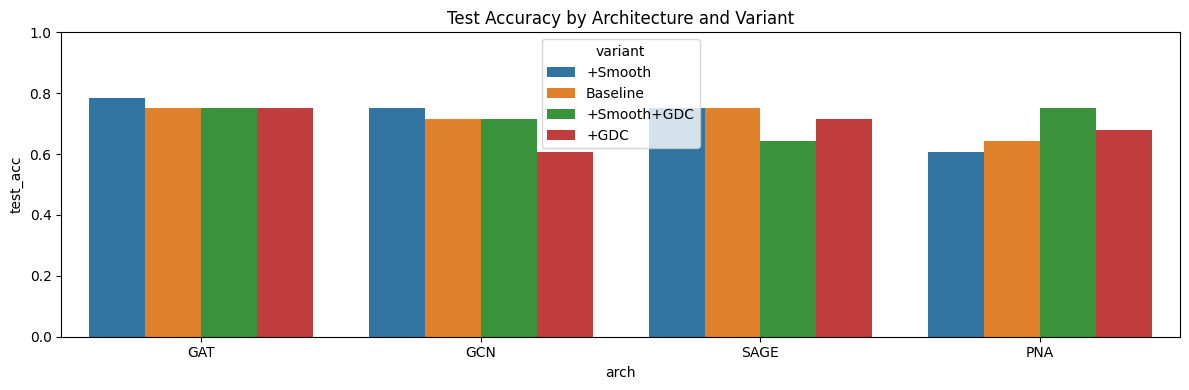

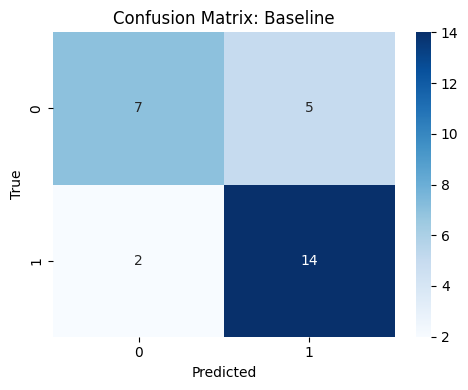

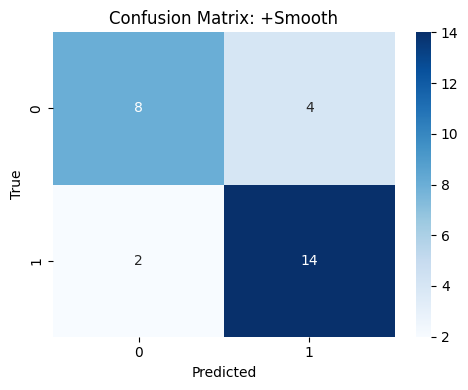

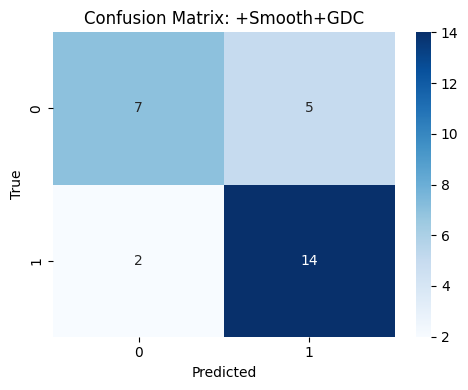

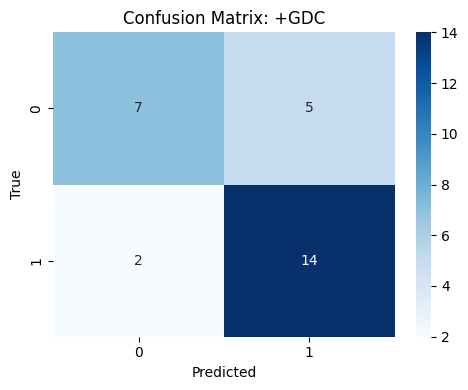

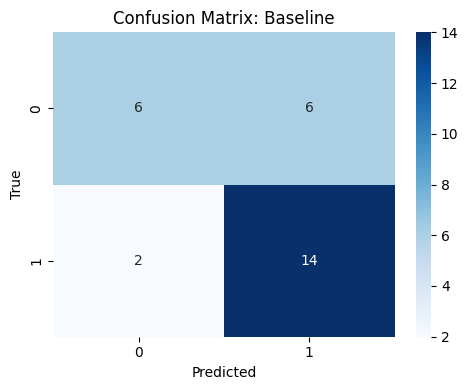

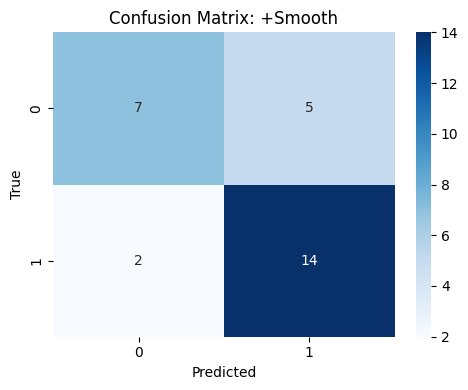

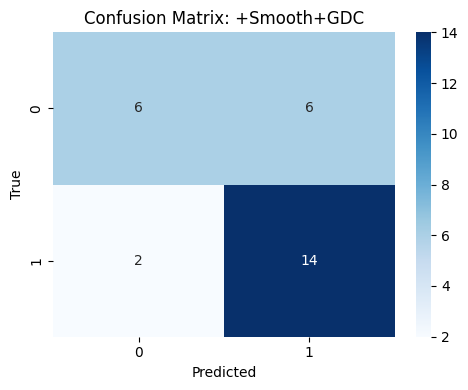

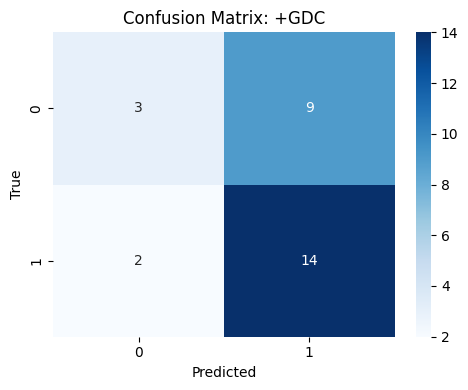

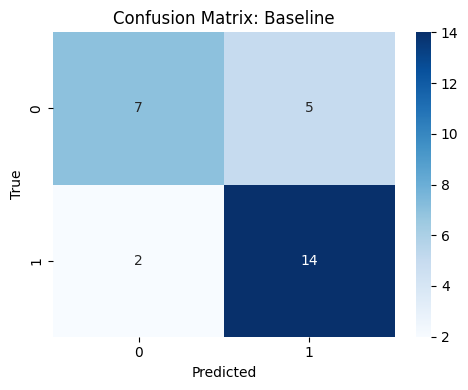

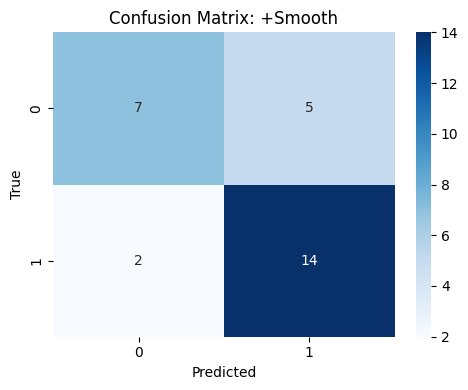

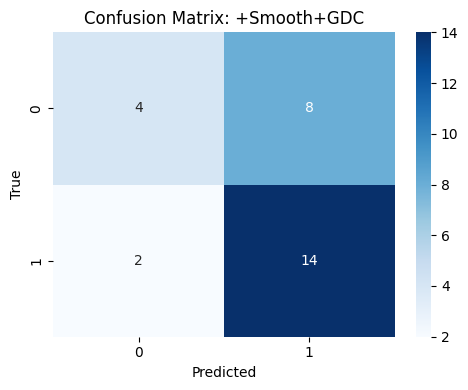

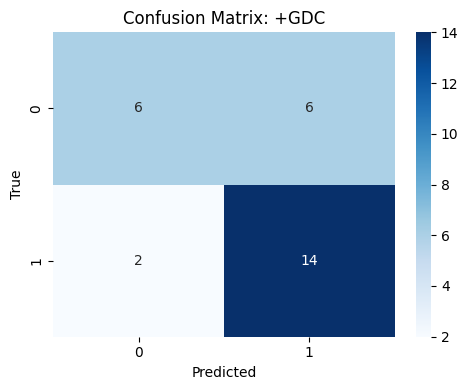

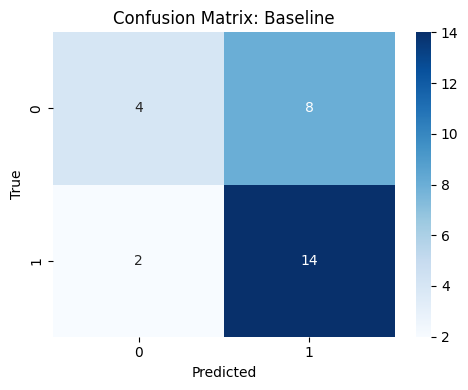

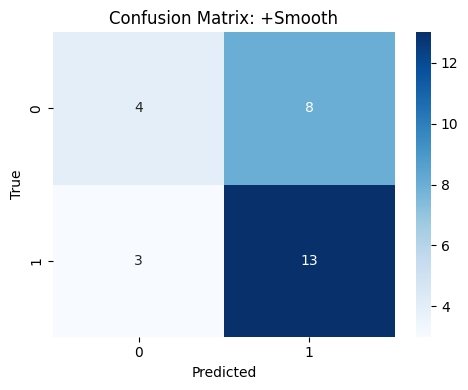

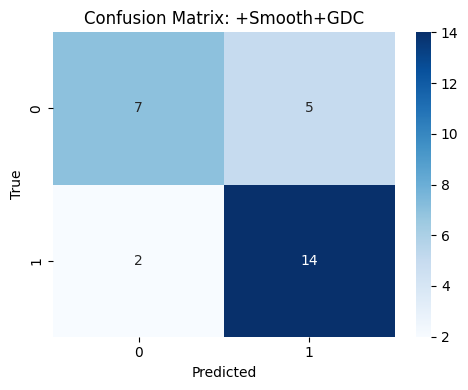

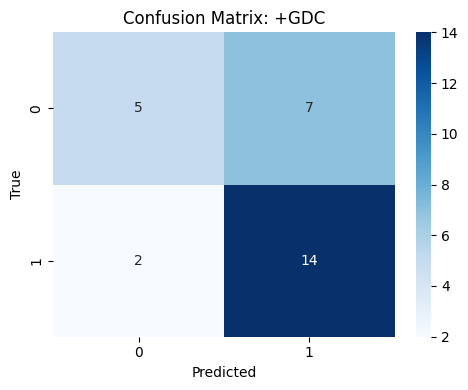

In [13]:
ckpt_dirs = ['gat_refine_ckpts','gcn_refine_ckpts','sage_refine_ckpts','pna_refine_ckpts']
rows = []
for d in ckpt_dirs:
    dpath = Path(d)
    if not dpath.exists():
        continue
    for mfile in dpath.glob('*_metrics.json'):
        with open(mfile) as f:
            m = json.load(f)
        rows.append({
            'arch': m.get('arch'),
            'variant': m.get('variant'),
            'best_val_acc': m.get('best_val_acc'),
            'test_acc': m.get('test_acc'),
            'dir': d
        })
metrics_df = pd.DataFrame(rows)
if metrics_df.empty:
    print('No saved metrics found. Run the training cell first.')
else:
    plt.figure(figsize=(12,4))
    sns.barplot(data=metrics_df, x='arch', y='test_acc', hue='variant')
    plt.ylim(0,1)
    plt.title('Test Accuracy by Architecture and Variant')
    plt.tight_layout()
    plt.savefig(plots_dir / 'summary_test_accuracy.png', dpi=150)
    plt.show()
    # Show confusion matrices
    for d in ckpt_dirs:
        dpath = Path(d)
        if not dpath.exists(): continue
        for cm_csv in dpath.glob('*_confusion_matrix.csv'):
            cm = pd.read_csv(cm_csv, header=None).values
            name = cm_csv.stem.replace('_confusion_matrix','')
            plt.figure(figsize=(5,4))
            sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_order, yticklabels=label_order)
            plt.title(f'Confusion Matrix: {name}')
            plt.xlabel('Predicted'); plt.ylabel('True')
            plt.tight_layout()
            plt.savefig(plots_dir / f'{name}_cm.png', dpi=150)
            plt.show()

In [14]:
# One-liner quick run (set to builtin MUTAG and run few epochs)
DO_QUICK_RUN = False
if DO_QUICK_RUN:
    DATA_MODE = 'builtin'
    BUILTIN_DATASET = 'MUTAR' if False else 'MUTAG'
    epochs = 10
    batch_size = 16
    # Rebuild data & loaders
    train_graphs, val_graphs, test_graphs, label_order = load_builtin_graphs(BUILTIN_DATASET, BUILTIN_ROOT)
    train_variants = make_variants(train_graphs)
    val_variants   = make_variants(val_graphs)
    test_variants  = make_variants(test_graphs)
    train_loaders = make_loaders(train_variants, batch_size=batch_size, shuffle_train=True)
    val_loaders   = make_loaders(val_variants,   batch_size=batch_size, shuffle_train=False)
    test_loaders  = make_loaders(test_variants,  batch_size=batch_size, shuffle_train=False)
    all_results = run_all(train_loaders, val_loaders, test_loaders, label_order)
    # Tiny summary
    for arch, res in all_results.items():
        for var, info in res.items():
            print(f"{arch:4s} | {var:12s} | Val {info['best_val_acc']:.3f} | Test {info['test_acc']:.3f}")

## Aggregate Results and Plot
Collect metrics JSONs and plot bar charts + confusion matrices.

In [15]:
# Quick smoke test configuration (optional): set small epochs for a fast run
SMOKE_TEST = True
if DATA_MODE == 'builtin' and SMOKE_TEST:
    epochs = 10
    batch_size = 8
    print('Smoke test enabled for builtin dataset: epochs=10, batch_size=8')
    # Rebuild loaders with updated batch_size
    train_variants = make_variants(train_graphs)
    val_variants   = make_variants(val_graphs)
    test_variants  = make_variants(test_graphs)
    train_loaders = make_loaders(train_variants, batch_size=batch_size, shuffle_train=True)
    val_loaders   = make_loaders(val_variants,   batch_size=batch_size, shuffle_train=False)
    test_loaders  = make_loaders(test_variants,  batch_size=batch_size, shuffle_train=False)

Smoke test enabled for builtin dataset: epochs=10, batch_size=8
GDC (topology) failed; using original. Err: 
Smooth+GDC failed; using original. Err: 
GDC feature smoothing failed; using original. Err: 
GDC (topology) failed; using original. Err: 
Smooth+GDC failed; using original. Err: 
GDC feature smoothing failed; using original. Err: 
GDC (topology) failed; using original. Err: 
Smooth+GDC failed; using original. Err: 
GDC feature smoothing failed; using original. Err: 
GDC (topology) failed; using original. Err: 
Smooth+GDC failed; using original. Err: 
GDC feature smoothing failed; using original. Err: 
GDC (topology) failed; using original. Err: 
Smooth+GDC failed; using original. Err: 
GDC feature smoothing failed; using original. Err: 
GDC (topology) failed; using original. Err: 
Smooth+GDC failed; using original. Err: 
GDC feature smoothing failed; using original. Err: 
GDC (topology) failed; using original. Err: 
Smooth+GDC failed; using original. Err: 
GDC feature smoothing 

NameError: name 'make_loaders' is not defined

In [ ]:
ckpt_dirs = ['gat_refine_ckpts','gcn_refine_ckpts','sage_refine_ckpts','pna_refine_ckpts']
rows = []
for d in ckpt_dirs:
    dpath = Path(d)
    if not dpath.exists():
        continue
    for mfile in dpath.glob('*_metrics.json'):
        with open(mfile) as f:
            m = json.load(f)
        rows.append({
            'arch': m.get('arch'),
            'variant': m.get('variant'),
            'best_val_acc': m.get('best_val_acc'),
            'test_acc': m.get('test_acc'),
            'dir': d
        })
metrics_df = pd.DataFrame(rows)
if metrics_df.empty:
    print('No saved metrics found. Run the training cell first.')
else:
    plt.figure(figsize=(10,4))
    sns.barplot(data=metrics_df, x='arch', y='test_acc', hue='variant')
    plt.ylim(0,1)
    plt.title('Test Accuracy by Architecture and Variant')
    plt.tight_layout()
    plt.savefig(plots_dir / 'summary_test_accuracy.png', dpi=150)
    plt.show()
    # Show confusion matrices
    for d in ckpt_dirs:
        dpath = Path(d)
        if not dpath.exists(): continue
        for cm_csv in dpath.glob('*_confusion_matrix.csv'):
            cm = pd.read_csv(cm_csv, header=None).values
            name = cm_csv.stem.replace('_confusion_matrix','')
            plt.figure(figsize=(5,4))
            sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_order, yticklabels=label_order)
            plt.title(f'Confusion Matrix: {name}')
            plt.xlabel('Predicted'); plt.ylabel('True')
            plt.tight_layout()
            plt.savefig(plots_dir / f'{name}_cm.png', dpi=150)
            plt.show()

In [ ]:
# Plot learning curves: epoch vs validation accuracy per architecture and variant
import glob
curve_dirs = ['gat_refine_ckpts','gcn_refine_ckpts','sage_refine_ckpts','pna_refine_ckpts']
curves = []
for d in curve_dirs:
    dpath = Path(d)
    if not dpath.exists():
        continue
    for jf in dpath.glob('*_curves.json'):
        with open(jf) as f:
            info = json.load(f)
        arch = info.get('arch') or jf.stem.split('_')[0]
        variant = info.get('variant') or jf.stem.split('_',1)[-1].replace('_curves','')
        va = info.get('val_acc', [])
        curves.append({'arch': arch, 'variant': variant, 'val_acc': va, 'path': str(jf)})
if not curves:
    print('No curve files found. Run training first.')
else:
    # Plot per architecture
    for arch in sorted({c['arch'] for c in curves}):
        arch_curves = [c for c in curves if c['arch']==arch]
        plt.figure(figsize=(8,5))
        for c in arch_curves:
            y = c['val_acc']
            x = list(range(1, len(y)+1))
            plt.plot(x, y, marker='o', linewidth=1.5, label=c['variant'])
        plt.title(f'Validation Accuracy vs Epoch — {arch}')
        plt.xlabel('Epoch'); plt.ylabel('Val Accuracy'); plt.ylim(0,1)
        plt.grid(True, alpha=0.3)
        plt.legend()
        outp = plots_dir / f'{arch}_val_acc_curves.png'
        plt.tight_layout(); plt.savefig(outp, dpi=150)
        plt.show()
    # Combined plot across architectures for each variant
    for variant in sorted({c['variant'] for c in curves}):
        vcurves = [c for c in curves if c['variant']==variant]
        if not vcurves:
            continue
        plt.figure(figsize=(8,5))
        for c in vcurves:
            y = c['val_acc']
            x = list(range(1, len(y)+1))
            plt.plot(x, y, marker='o', linewidth=1.5, label=c['arch'])
        plt.title(f'Validation Accuracy vs Epoch — {variant}')
        plt.xlabel('Epoch'); plt.ylabel('Val Accuracy'); plt.ylim(0,1)
        plt.grid(True, alpha=0.3)
        plt.legend()
        outp = plots_dir / f'variant_{variant.replace("+","plus").replace(" ","_")}_val_acc_curves.png'
        plt.tight_layout(); plt.savefig(outp, dpi=150)
        plt.show()

In [ ]:
# New method: GDC-based feature smoothing (user function + wrapper)
import numpy as np
import scipy.sparse as sp
from torch_geometric.utils import to_scipy_sparse_matrix

.
def gdc(A: sp.csr_matrix, alpha: float, eps: float):
    N = A.shape[0]
    # Self-loops
    A_loop = sp.eye(N) + A
    # Symmetric transition matrix
    D_loop_vec = A_loop.sum(0).A1
    D_loop_vec_invsqrt = 1 / np.sqrt(D_loop_vec)
    D_loop_invsqrt = sp.diags(D_loop_vec_invsqrt)
    T_sym = D_loop_invsqrt @ A_loop @ D_loop_invsqrt
    # PPR-based diffusion
    S = alpha * sp.linalg.inv(sp.eye(N) - (1 - alpha) * T_sym)
    print(" S shape")
    print(S.shape)
    # Sparsify using threshold epsilon
    S_tilde = S.multiply(S >= eps)
    # Column-normalized transition matrix on graph S_tilde
    D_tilde_vec = S_tilde.sum(0).A1
    T_S = S_tilde / D_tilde_vec
    print(" TS shape")
    print(T_S.shape)
    return S

.
def apply_gdc_feature_smoothing_to_graph(data, alpha: float = 0.15, eps: float = 1e-4):
    """Apply user-provided GDC diffusion on topology to smooth node features: X' = S X."""
    num_nodes = data.num_nodes
    A = to_scipy_sparse_matrix(data.edge_index, getattr(data,'edge_attr', None), num_nodes=num_nodes).tocsr()
    S = gdc(A, alpha=alpha, eps=eps)  # returns S (not T_S) per the provided function
    X = data.x.detach().cpu().numpy().astype(np.float64)
    X_s = (S @ sp.csr_matrix(X)).A  # use sparse-dense matmul
    new_data = data.clone()
    new_data.x = torch.from_numpy(X_s).to(data.x.device, dtype=data.x.dtype)
    return new_data